In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

import numpy as np
import pickle, os, torch, cv2, imageio

from src.data_loading import loading
from src.modeling import glam as glam

In [2]:
#for n in range(0, 191, 1):
    n=14
    with open("sample_output/Glam_1/nyu_glam.pkl", "rb") as f:
        exam_list = pickle.load(f)
    datum = exam_list[n]#####################################################################################
    view = "R-CC"
    short_file_path = datum[view][0]
    
    loaded_image2 = loading.load_image(
                        image_path=os.path.join("sample_output/Glam_1/cropped_images/", short_file_path + ".png"),
                        view=view, horizontal_flip="NO")
    
    loaded_image = loading.process_image(loaded_image2, view, datum["best_center"][view][0])############Reference
    
    parameters = {
        "device_type":"cpu",
        "cam_size": (184,120), 
        "top_k_per_class": 1,
        "crop_shape": (512, 512),
        "percent_k":0.03,
        "detection_pooling_percent_k":0.3,
        "fusion": True
        }   
    

    model = glam.MILSingleImageModel(parameters)
    model.load_state_dict(torch.load("models/model_joint.ckpt", map_location="cpu"), strict=False)

    tensor_batch = torch.Tensor(np.expand_dims(np.expand_dims(loaded_image, 0), 0).copy()) #La imagen como tensor
    output = model(tensor_batch) #Prediccion de la imagen
    saliency_maps = model.saliency_map_local.data.cpu()
    heatmap = saliency_maps[0,1,:,:]
    heatmap2 = heatmap.numpy()
    heatmap2 = cv2.resize(heatmap2, (1920, 2944)) #####################################################Reference
    # interpolate the heatmap
    img = cv2.imread("sample_output/Glam_1/cropped_images/" + short_file_path + ".png")#######Read cropped image
    input_size=(2944, 1920)
    borders = loading.bordbord(loaded_image2, view, datum["best_center"][view][0])
    ########################################################
    if (view == "R-MLO")or(view == "R-CC"):#ok
        img2 = cv2.flip(img, 1)   
    else:
        img2 = img
    ########################################################
    cropped_image = img2[borders[0]: borders[1], borders[2]: borders[3]]#############Se recorta como loaded_image
    ########################################################
    if (np.shape(loaded_image) != np.shape(cropped_image[:,:,1])):#ok
        if (view == "L-MLO") or (view == "R-MLO"):#ok
            newc = np.zeros((np.shape(loaded_image)[0],np.shape(loaded_image)[1],3),np.uint8)#ok
            newc[0:np.shape(cropped_image)[0],0:np.shape(cropped_image)[1],:] = cropped_image#ok
            heatheat = heatmap2[0:np.shape(cropped_image)[0],0:np.shape(cropped_image)[1]]#ok
            
        else:
            newc = np.zeros((np.shape(loaded_image)[0],np.shape(loaded_image)[1],3),np.uint8)#ok
            A = int((np.shape(loaded_image)[0]-np.shape(cropped_image)[0])/2)#ok
            newc[A:A+np.shape(cropped_image)[0],0:np.shape(cropped_image)[1],:] = cropped_image#ok
            heatheat = heatmap2[A:A+np.shape(cropped_image)[0],0:np.shape(cropped_image)[1]]#ok
            
    else:
        newc = cropped_image
        heatheat = heatmap2
    ########################################################  
    heatheat2 = np.zeros((np.shape(img)[0],np.shape(img)[1]))#ok
    heatheat2[borders[0]: borders[1], borders[2]: borders[3]] = heatheat#ok    
    ########################################################
    if (view == "R-MLO")or(view == "R-CC"):
        heatheat3 = cv2.flip(heatheat2, 1)   
    else:
        heatheat3 = heatheat2
    imht = np.uint8(255*heatheat3)
    #Guardar GrayHeatmaps:
    #imageio.imsave('sample_output/GrayHeatmaps/' + short_file_path + '_CAM2.png', imht)
    
    #Guardar ColorHeatmaps:
    imht1 = cv2.applyColorMap(imht, cv2.COLORMAP_JET)
    superimposed_img = imht1* 0.4 + img*0.6#OriginalCropped
    #cv2.imwrite('sample_output/ColorHeatmaps/' + short_file_path + '_CAM2_EXAMPLE.jpg', superimposed_img)
    
    
    

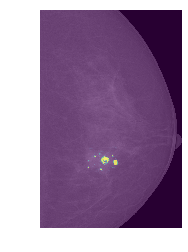

In [3]:
plt.imshow(loaded_image,  cmap='gray')#################
plt.imshow(heatmap2, alpha=0.6)
plt.axis("off")
plt.show()

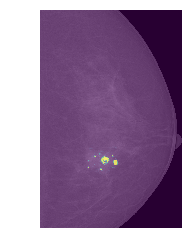

In [4]:
plt.imshow(newc)################### 
plt.imshow(heatmap2, alpha=0.6)
plt.axis("off")
plt.show()

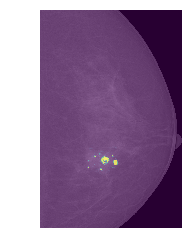

In [5]:
plt.imshow(cropped_image)################# 
plt.imshow(heatheat, alpha=0.6)
#plt.imshow(cv2.flip(heatheat2,1), alpha=0.6)
plt.axis("off")
plt.show()

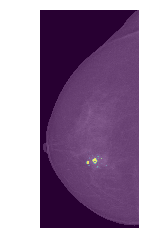

In [6]:
plt.imshow(img)#################
plt.imshow(heatheat3, alpha=0.6)
#plt.imshow(cv2.flip(heatheat2,1), alpha=0.6)
plt.axis("off")
plt.show()